This notebook goes through a simple binary classification example, explaining general library functionality and data loading along the way.

We perform binary classification on sex, using structural MRI rois.

# Init Phase

In [1]:
from ABCD_ML.ABCD_ML import ABCD_ML

Using TensorFlow backend.


Replace these values below with your own directory / desired files.

In [2]:
#Define directory with the 2.0_NDA_Data
nda_dr = '/mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/'

#This file stores the name mapping
test_mapping_loc = nda_dr + 'ABCD_Release_ Notes_Data_Release_ 2.0/22. ABCD_Release_2.0_mapping_r.csv'

#We will use as the neuroimaging data just the sMRI data
test_data_loc1 = nda_dr + 'MRI/ABCD sMRI Part 1.csv'
test_data_loc2 = nda_dr + 'MRI/ABCD sMRI Part 2.csv'

#We will load target data (and covariate data) from here
test_target_loc = nda_dr + 'Mental Health/ABCD Parent Demographics Survey.csv'

#We will load stratification data from here
test_strat_loc = nda_dr + 'Other Non-Imaging/ABCD ACS Post Stratification Weights.csv'

#We will load exclusions from here, it is the list of flipped subject ids
test_exclusion_loc = '/home/sage/bader_things/invalid_pguids.txt'

We first need to define the class object, which we will use to load load and to train/test different ML models.
There are a few global parameters which we can optionally set when defining this object as well, lets look and see what they are.

In [3]:
help(ABCD_ML.__init__)

Help on function __init__ in module ABCD_ML.ABCD_ML:

__init__(self, exp_name='some_exp', log_dr='', existing_log='new', verbose=True, notebook=True, subject_id='src_subject_id', eventname='baseline_year_1_arm_1', use_default_subject_ids=True, default_dataset_type='basic', default_na_values=['777', '999'], original_targets_key='targets', low_memory_mode=False, random_state=None)
    Main class init
    
    Parameters
    ----------
    exp_name : str, optional
        The name of this experimental run,
        used explicitly in saving logs, and figures.
        If log_dr is not set to None-
        (if not None then saves logs and figures)
        then a folder is created within the log dr
        with the exp_name.
    
        (default = 'some_exp')
    
    log_dr : str, Path or None, optional
        The directory in which to store logs...
        If set to None, then will not save any logs!
        If set to '', will save in the current dr.
    
        (default = '')
    
    e

Most of the default parameters are okay for this simple example, but any of them can be changed.

One thing we want to change just to make things easier is setting the default_dataset_type field, as in this example all of the datasets we are loading from are 'explorer' type. This way we won't have to pass that to every loader.

In [4]:
ML = ABCD_ML(default_dataset_type='explorer', existing_log='overwrite')

exp_name = some_exp
log_dr = /home/sage/ABCD_ML/Examples
existing_log = overwrite
verbose = True
exp log dr setup at: /home/sage/ABCD_ML/Examples/some_exp
log file at: /home/sage/ABCD_ML/Examples/some_exp/logs.txt
notebook = True
default subject id col = src_subject_id
eventname = baseline_year_1_arm_1
use default subject ids = True
default dataset type = explorer
default NaN values = ['777', '999']
original targets key col = targets
low memory mode = False
random state = None
ABCD_ML object initialized


# Data Loading Phase

We can continue by optionally loading in a name map, which is simply a dictionary that attempts to rename any column names loaded in, if those column names are a key in the dictionary. This is useful for ABCD data as the default column names might not be useful.

Note this name map and these parameters are for the 'ABCD 2.0 Explorer' formatting. 

In [5]:
ML.Load_Name_Map(loc = test_mapping_loc,
                 source_name_col = "NDAR name",
                 target_name_col = "REDCap name/NDA alias")

Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/ABCD_Release_ Notes_Data_Release_ 2.0/22. ABCD_Release_2.0_mapping_r.csv assumed to be dataset type: explorer
Loaded map file


We can look at what exactly is in this dictionary if we want to confirm we loaded it correctly.
It is loaded as name_map within the ABCD_ML class.

In [6]:
some_examples = {k: ML.name_map[k] for k in list(ML.name_map)[300:320]}
some_examples

{'ddtidp_674': 'dmri_dtifagm_cortdestrieux_ssuborbitallh',
 'ddtidp_748': 'dmri_dtifagm_cortdestrieux_ssuborbitalrh',
 'ddtidp_675': 'dmri_dtifagm_cortdestrieux_ssubparietallh',
 'ddtidp_749': 'dmri_dtifagm_cortdestrieux_ssubparietalrh',
 'ddtidp_676': 'dmri_dtifagm_cortdestrieux_stemporalinflh',
 'ddtidp_750': 'dmri_dtifagm_cortdestrieux_stemporalinfrh',
 'ddtidp_677': 'dmri_dtifagm_cortdestrieux_stemporalsuplh',
 'ddtidp_751': 'dmri_dtifagm_cortdestrieux_stemporalsuprh',
 'ddtidp_678': 'dmri_dtifagm_cortdestrieux_stemporaltransverselh',
 'ddtidp_752': 'dmri_dtifagm_cortdestrieux_stemporaltransverserh',
 'dmri_dtifagwc_cdsn_bslh': 'dmri_dtifagwc_cortdesikan_banksstslh',
 'dmri_dtifagwc_cdsn_bsrh': 'dmri_dtifagwc_cortdesikan_banksstsrh',
 'dmri_dtifagwc_cdsn_cdacatelh': 'dmri_dtifagwc_cortdesikan_caudalanteriorcingulatelh',
 'dmri_dtifagwc_cdsn_cdacaterh': 'dmri_dtifagwc_cortdesikan_caudalanteriorcingulaterh',
 'dmri_dtifagwc_cdsn_cdmflh': 'dmri_dtifagwc_cortdesikan_caudalmiddlefrontal

In [7]:
help(ML.Load_Exclusions)

Help on method Load_Exclusions in module ABCD_ML._Data:

Load_Exclusions(loc=None, exclusions=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Loads in a set of excluded subjects,
    from either a file or as directly passed in.
    
    Parameters
    ----------
    loc : str, Path or None, optional
        Location of a file to load in excluded subjects from.
        The file should be formatted as one subject per line.
        (default = None)
    
    exclusions : list, set, array-like or None, optional
        An explicit list of subjects to add to exclusions.
        (default = None)
    
    Notes
    ----------
    For best/most reliable performance across all data loading cases,
    exclusions should be loaded before data, covars and targets.
    
    If default subject id behavior is set to False,
    reading subjects from a exclusion loc might not
    function as expected.



For our exclusions we will just use the flipped subjects

In [8]:
ML.Load_Exclusions(loc=test_exclusion_loc)

Total excluded subjects:  1137
Removed excluded subjects from loaded dfs


Next, we will load in the actual data. Like before we can check what parameters this function wants / can accept

In [9]:
help(ML.Load_Data)

Help on method Load_Data in module ABCD_ML._Data:

Load_Data(loc, dataset_type='default', drop_keys=[], filter_outlier_percent=None, winsorize_val=None, drop_col_duplicates=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Load a ABCD2p0NDA (default) or 2.0_ABCD_Data_Explorer (explorer)
    release formatted neuroimaging dataset - of derived ROI level info.
    
    Parameters
    ----------
    loc : str, Path or list of
        The location of the csv file to load data load from.
        If passed a list, then will load each loc in the list,
        and will assume them all to be of the same dataset_type if one
        dataset_type is passed, or if they differ in type, a list must be
        passed to dataset_type with the different types in order.
    
        Note: some proc will be done on each loaded dataset before merging
        with the rest (duplicate subjects, proc for eventname ect...), but
        other dataset loading behavior won't occur until after the merge,
       

In [10]:
ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
             dataset_type='explorer',
             filter_outlier_percent=.005, 
             winsorize_val=.01)           

Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 1.csv assumed to be dataset type: explorer
dropped ['abcd_smrip101_id', 'dataset_id', 'smri_visitid'] columns by default  due to dataset type
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 2.csv assumed to be dataset type: explorer
dropped ['abcd_smrip201_id', 'dataset_id'] columns by default  due to dataset type
Dropped 0 columns, per drop_keys argument
Dropped 10 cols for all missing values
Dropped 1084 rows for missing values
Dropped rows with missing data
Filtered data for outliers with value:  0.005
Winsorized data with value:  0.01
loaded shape:  (948, 1186)

The following columns have a questionable number of unique values: 
smri_area_cortdesikan_frontalpolelh unique vals: 140
smri_area_cortdesikan_frontalpolerh unique vals: 182
smri_vol_subcortaseg_wmhypointensitieslh unique vals: 1
smri_vol_subcortaseg_wmhypointensitiesrh unique vals: 1


Total valid overlapping subjects = 948



That ends up being a lot of data dropped just for dropping missing outliers... since we are not in low_memory_mode, we can just clear the data, and reload it. This time we will also load not just the first data loc, but the rest as well - and at the same time - but just providing the locations of both in a list.

In [11]:
ML.Clear_Data()

cleared data.


In [12]:
ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
             dataset_type='explorer', #This is set as default, but how we would specify it if we wanted to change i
             filter_outlier_percent=.0005, 
             winsorize_val=.001)   

Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 1.csv assumed to be dataset type: explorer
dropped ['abcd_smrip101_id', 'dataset_id', 'smri_visitid'] columns by default  due to dataset type
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 2.csv assumed to be dataset type: explorer
dropped ['abcd_smrip201_id', 'dataset_id'] columns by default  due to dataset type
Dropped 0 columns, per drop_keys argument
Dropped 10 cols for all missing values
Dropped 1084 rows for missing values
Dropped rows with missing data
Filtered data for outliers with value:  0.0005
Winsorized data with value:  0.001
loaded shape:  (6763, 1186)

The following columns have a questionable number of unique values: 
smri_thick_cortdesikan_banksstslh unique vals: 848
smri_thick_cortdesikan_caudalanteriorcingulatelh unique vals: 1097
smri_thick_cortdesikan_caudalmiddlefrontallh unique vals: 755
smri_thick_cortdesikan_cuneuslh unique vals: 750
smri_thick_cortdesikan_fusifo

These seem okay settings.

Our data for this expiriment should now be loaded. We can check it out:

In [13]:
ML.data.head()

,smri_thick_cortdesikan_banksstslh,smri_thick_cortdesikan_caudalanteriorcingulatelh,smri_thick_cortdesikan_caudalmiddlefrontallh,smri_thick_cortdesikan_cuneuslh,smri_thick_cortdesikan_entorhinallh,smri_thick_cortdesikan_fusiformlh,smri_thick_cortdesikan_inferiorparietallh,smri_thick_cortdesikan_inferiortemporallh,smri_thick_cortdesikan_isthmuscingulatelh,smri_thick_cortdesikan_lateraloccipitallh,...,smri_t2w_subcortaseg_hippocampusrh,smri_t2w_subcortaseg_amygdalarh,smri_t2w_subcortaseg_accumbensarearh,smri_t2w_subcortaseg_ventraldcrh,smri_t2w_subcortaseg_wmhypointensities,smri_t2w_subcortaseg_ccposterior,smri_t2w_subcortaseg_ccmidposterior,smri_t2w_subcortaseg_cccentral,smri_t2w_subcortaseg_ccmidanterior,smri_t2w_subcortaseg_ccanterior
src_subject_id,,,,,,,,,,,,,,,,,,,,,
NDAR_INV00R4TXET,2.817,3.372,3.012,2.155,3.115,2.810,2.854,3.147,2.629,2.348,...,166.147666,171.143448,152.634040,115.660336,152.816743,106.990743,120.449265,117.044747,112.399884,109.441508
NDAR_INV00UMK5VC,2.685,2.666,2.895,1.987,3.107,2.947,2.887,3.256,2.434,2.350,...,170.350490,154.837096,133.076824,116.094815,147.913201,98.521998,131.900032,122.047120,102.673528,105.812915
NDAR_INV014RTM1V,2.783,2.999,2.956,2.030,3.170,2.940,2.718,3.014,2.444,2.266,...,166.764158,164.723606,163.940763,117.205626,211.238987,106.615366,125.595535,119.674263,116.918631,111.743396
NDAR_INV019DXLU4,2.944,3.078,2.931,2.166,3.459,2.980,2.785,3.080,2.677,2.360,...,159.890286,151.097159,145.289319,114.540321,140.991964,102.489477,110.442037,100.033514,102.737771,112.328037
NDAR_INV01ELX9L6,2.861,2.400,2.898,2.101,4.043,2.939,2.677,2.811,3.035,2.202,...,147.023012,148.368816,153.563722,112.275222,141.126298,102.607760,107.345429,103.728713,105.512885,106.459537


In [14]:
ML.data.shape

(6763, 1186)

Great. Now that data is loaded we still need to load targets, and can optionally load covars, strat and exclusions. Lets load our target first, and begin as before by checking out the loading function.

In [15]:
help(ML.Load_Targets)

Help on method Load_Targets in module ABCD_ML._Data:

Load_Targets(loc, col_name, data_type, dataset_type='default', filter_outlier_percent=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Loads in a set of subject ids and associated targets from a
    2.0_ABCD_Data_Explorer release formatted csv.
    See Notes for more info.
    
    Parameters
    ----------
    loc : str, Path or None
        The location of the csv file to load targets load from.
    
    col_name : str
        The name of the column to load.
    
    data_type : {'binary', 'categorical', 'ordinal', 'float'}
        The data type of the targets column.
        Shorthands for datatypes can be used as well
    
        - 'binary' or 'b' : Binary input
        - 'categorical' or 'c' : Categorical input
        - 'ordinal' or 'o' : Ordinal input
        - 'float' or 'f' : Float numerical input
    
        Datatypes are explained further in Notes.
    
    dataset_type : {'default', 'basic', 'explorer', 'custom'}, 

Great, lets just load in sex as our target variable.

In [16]:
ML.Load_Targets(loc=test_target_loc,
                col_name='demo_sex_v2',
                data_type='b')

Loading targets!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Mental Health/ABCD Parent Demographics Survey.csv assumed to be dataset type: explorer
More than two unique score values found, filtered all but [1. 2.]
Final shape:  (10737, 1)

Total valid overlapping subjects = 6758



If you read the verbose print out above, you'll notice that it says "More than two unique score values found,filtered all but [1. 2.]" This is because by default when a binary datatype is passed, the dataloader needs to make sure it loads in only two unique values. To solve this when there exists outliers, like in this case, all but the top two unique values by count will be dropped. It will further show which values it has kept, in the case that an error was made, but here 1 and 2 are the correct sex values. If more than two values are desired, the categorical data type should be used.

Let's look and see to make sure everything was loaded correctly.

In [17]:
ML.targets.head()

,targets
src_subject_id,
NDAR_INV0A4ZDYNL,0
NDAR_INV0BKE31EY,0
NDAR_INV0CBFTKR7,0
NDAR_INV0CCEN5K2,0
NDAR_INV0DC9BJZK,0


We can look into adding covars next. Where co-variates arn't quite treated as typical co-variates, but are values we would like to be able to pass as additional input to the ML model if desired (and input that is treated in a special way, specifically covar input won't be scaled with any data scaler by default). 

In [18]:
help(ML.Load_Covars)

Help on method Load_Covars in module ABCD_ML._Data:

Load_Covars(loc, col_names, data_types, dataset_type='default', code_categorical_as='dummy', filter_float_outlier_percent=None, standardize=True, normalize=False) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Load a covariate or covariates from a 2.0_ABCD_Data_Explorer
    release formatted csv.
    
    Parameters
    ----------
    loc : str, Path or None
        The location of the csv file to load co-variates load from.
    
    col_names : str or list
        The name(s) of the column(s) to load.
    
        Note: Must be in the same order as data types passed in.
    
    data_types : {'binary', 'categorical', 'ordinal', 'float'} or list of
        The data types of the different columns to load,
        in the same order as the column names passed in.
        Shorthands for datatypes can be used as well
    
        - 'binary' or 'b' : Binary input
        - 'categorical' or 'c' : Categorical input
        - 'ordinal' or 'o'

In [19]:
ML.Load_Covars(loc=test_target_loc,
               col_names = 'demo_ed_v2',
               data_types = 'o',
               standardize = False,
               normalize = False) 

Loading covariates!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Mental Health/ABCD Parent Demographics Survey.csv assumed to be dataset type: explorer
load: demo_ed_v2

Total valid overlapping subjects = 6758



And check to see it was loaded correctly (and normalized)

In [20]:
ML.covars.head()

,demo_ed_v2
src_subject_id,
NDAR_INV0A4ZDYNL,5.0
NDAR_INV0BKE31EY,3.0
NDAR_INV0CBFTKR7,5.0
NDAR_INV0CCEN5K2,3.0
NDAR_INV0DC9BJZK,6.0


Lastly, we will considering loading different stratification values. These are the values that we can optionally define custom validation / split behavior on. Within this example, we are just going to make sure that all splits preserve subjects with the same family id within the same fold, so lets load family id - after looking as the help function.

In [21]:
help(ML.Load_Strat)

Help on method Load_Strat in module ABCD_ML._Data:

Load_Strat(loc, col_names, dataset_type='default', binary_col_inds=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Load stratification values from a file.
    See Notes for more details on what stratification values are.
    
    Parameters
    ----------
    loc : str, Path or None
        The location of the csv file to load stratification vals from.
    
    col_names : str or list
        The name(s) of the column(s) to load.
    
    dataset_type : {'default', 'basic', 'explorer', 'custom'}, optional
        The type of file to load from.
        Dataset types are,
    
        - 'default' : Use the class defined default dataset type,            if not set by the user this is 'basic'.
    
        - 'basic' : ABCD2p0NDA style (.txt and tab seperated)
    
        - 'explorer' : 2.0_ABCD_Data_Explorer style (.csv and comma seperated)
    
        - 'custom' : A user-defined custom dataset. Right now this is only            su

In [22]:
ML.Load_Strat(loc=test_strat_loc,
              col_names='rel_family_id')

Reading strat/stratification values!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Other Non-Imaging/ABCD ACS Post Stratification Weights.csv assumed to be dataset type: explorer

Total valid overlapping subjects = 6756

Removing non overlapping subjects


In [23]:
ML.strat.head()

,rel_family_id
src_subject_id,
NDAR_INV9EVRB30H,80
NDAR_INVZVD13ZMG,7510
NDAR_INVDTHBFTNZ,1659
NDAR_INVLPY5VAXY,1281
NDAR_INVFL02R0H4,8156


Great, we now have our data, targets, covars, strat and exclusions loaded (Noting that the minimum requiriments for running an ML expiriment are just data or covars and targets, the rest being optional). The actual length of the script is also not as terrible as it seems, and once loading behavior is confirmed, verbose can even be turned off. To show this, we can re-load everything as above with verbose off. (Commented out, but you get the idea~)

In [24]:
#ML = ABCD_ML.ABCD_ML(verbose = False) # Reloading the ML object itself to reset everything.

#ML.Load_Exclusions(loc=test_exclusion_loc)

#ML.Load_Name_Map(loc = test_mapping_loc,
#                 source_name_col = "NDAR name",
#                 target_name_col = "REDCap name/NDA alias")

#ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
#             dataset_type='explorer',
#             filter_outlier_percent=.0005, 
#             winsorize_val=.01)

#ML.Load_Targets(loc=test_target_loc,
#                col_name='demo_sex_v2',
#                data_type='b')

#ML.Load_Covars(loc=test_target_loc,
#               col_names = 'demo_ed_v2',
#               data_types = 'ordinal',
#               standardize = False,
#               normalize = True)

#ML.Load_Strat(loc=test_strat_loc,
#              col_names='rel_family_id')

#ML.verbose = True

# Validation Phase

Lets move onto defining our validation stratagy (which is again optional, but as stated before for this example we are going to preserve family ids within the same folds), if no explicit validation strategy is defined, then random splits will be used.

In [25]:
help(ML.Define_Validation_Strategy)

Help on method Define_Validation_Strategy in module ABCD_ML.ABCD_ML:

Define_Validation_Strategy(groups=None, stratify=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Define a validation stratagy to be used during different train/test splits,
    in addition to model selection and model hyperparameter CV.
    See Notes for more info.
    
    Parameters
    ----------
    groups : str, list or None, optional
        In the case of str input, will assume the str to refer
        to a column key within the loaded strat data,
        and will assign it as a value to preserve groups by
        during any train/test or K-fold splits.
        If a list is passed, then each element should be a str,
        and they will be combined into all unique
        combinations of the elements of the list.
    
        (default = None)
    
    stratify : str, list or None, optional
        In the case of str input, will assume the str to refer
        to a column key within the loaded strat data,

So for group preserving behavior, as we are interested in keep families within the same folds, we supply an argument for groups. Specifically, we use the name of the column loaded within self.strat

In [26]:
ML.Define_Validation_Strategy(groups='rel_family_id')

CV defined with group preserving behavior, over 6107 unique values.


Lastly before we get to modelling, we want to define a global train-test split, so that we can perform model exploration, and parameter tuning ect... on a training set, and leave a left-out testing set to eventually test with out final selected model.

In [27]:
help(ML.Train_Test_Split)

Help on method Train_Test_Split in module ABCD_ML.ABCD_ML:

Train_Test_Split(test_size=None, test_loc=None, test_subjects=None, random_state=None) method of ABCD_ML.ABCD_ML.ABCD_ML instance
    Define the overarching train / test split, *highly reccomended*.
    
    Parameters
    ----------
    test_size : float, int or None, optional
        If float, should be between 0.0 and 1.0 and represent
        the proportion of the dataset to be included in the test split.
        If int, represents the absolute number (or target number) to
        include in the testing group.
        Set to None if using test_loc or test_subjects.
    
        (default = None)
    
    test_loc : str, Path or None, optional
        Location of a file to load in test subjects from.
        The file should be formatted as one subject per line.
    
        (default = None)
    
    test_subjects : list, set, array-like or None, optional
        An explicit list of subjects to constitute the testing set
    

In [28]:
ML.Train_Test_Split(test_size=.25, #Let be somewhat conservative, and use a size of .25
                    random_state=1)

Final data (w/ target) for modeling loaded shape: (6756, 1188)
Performed train/test split, train size: 5073 test size:  1683


Great - and because we set the validation stratagy to preserve family structure within the folds, we know that no family id is in both the train and test set - for the paranoid we can make sure of this.

In [29]:
train_ids = set(ML.strat['rel_family_id'].loc[ML.train_subjects])
test_ids = set(ML.strat['rel_family_id'].loc[ML.test_subjects])

print('Unique family ids in train: ', len(train_ids))
print('Unique family ids in test: ', len(test_ids))
print('Overlap : ', len(train_ids.intersection(test_ids)))

Unique family ids in train:  4580
Unique family ids in test:  1527
Overlap :  0


# Modeling Phase

Now we can proceed to modeling.

The main function we use here is Evaluate, we can look at its docstring, but from a very high level, this is the function we use to test different expirimental setups.

In [30]:
#help(ML.Evaluate)

Lets check what different model types we have avaliable for binary first.

In [31]:
#ML.Show_Model_Types(problem_type='binary')

We can also look at different metrics avaliable for binary classification, and different data scalers.

In [32]:
#ML.Show_Metrics(problem_type='binary')

In [33]:
#ML.Show_Data_Scalers(show_scaler_help=False, show_default_params=True)

We can also set some default ML params for some of the settings that we will be keeping the same.

In [34]:
#help(ML.Set_Default_ML_Params)

The parameters are mostly the same for setting default params as they are passed to Evaluate or Test. Importantly, by defining defaults, we define the value to be used if no value is passed to a given argument in Evaluate or Test.
Lets set some.

In [35]:
ML.Set_Default_ML_Params(problem_type = 'binary', #This will be staying the same
                         metric = ['macro roc auc', 'f1', 'accuracy'], #Lets set a few
                         data_scaler = 'standard', #Standard scaling is fine, but this can also be a list
                         n_splits = 2, #For the sake of quick run-time and this example 2 splits, no repeats
                         n_repeats = 1,
                         int_cv = 3,
                         class_weight = 'balanced', 
                         n_jobs = 8,
                         n_iter = 8,
                         random_state = 1)

No default sampler passed, set to None
No default feat selector passed, set to None
No default search type passed, set to None
No default data scaler param ind passed, set to 0
No default sampler param ind passed, set to 0
No default feat selector param ind passed, set to 0
No default extra params passed, set to empty dict
Default params set.



Now that we have some default ML params set, all we need to do to run an evaluation is simply:

In [49]:
raw_scores = ML.Evaluate(model_type='rf',
                         sampler='smote',
                         ensemble_type = 'basic ensemble',
                         ensemble_split = .2,
                         n_repeats=2)

Running Evaluate with:
model_type = rf
problem_type = binary
metric = ['macro roc auc', 'f1', 'accuracy']
data_scaler = standard
sampler = smote
feat_selector = None
n_splits = 2
n_repeats = 2
int_cv = 3
ensemble_type = basic ensemble
ensemble_split = 0.2
search_type = None
model_type_param_ind = 0
data_scaler_param_ind = 0
sampler_param_ind = 0
feat_selector_param_ind = 0
class_weight = balanced
n_jobs = 8
n_iter = 8
random_state = 1
extra_params = {}


Metric:  macro roc auc
Mean score:  0.8079676220718944
Macro std in score:  0.0008163884624737827
Micro std in score:  0.011657167107647257

Metric:  f1
Mean score:  0.7310797153129989
Macro std in score:  0.0023523657798844577
Micro std in score:  0.01723231490842776

Metric:  accuracy
Mean score:  0.7374207921875688
Macro std in score:  0.0010175070168443878
Micro std in score:  0.010132696276645895



In [70]:
import numpy as np
import shap

mean_shap_values = np.mean([np.array(ML.Model.shap_dfs[0]), np.array(ML.Model.shap_dfs[1])], axis=0)

In [71]:
train_data = ML.all_data.loc[ML.train_subjects].reindex(ML.Model.shap_dfs[1].index).drop(ML.targets_key, axis=1)


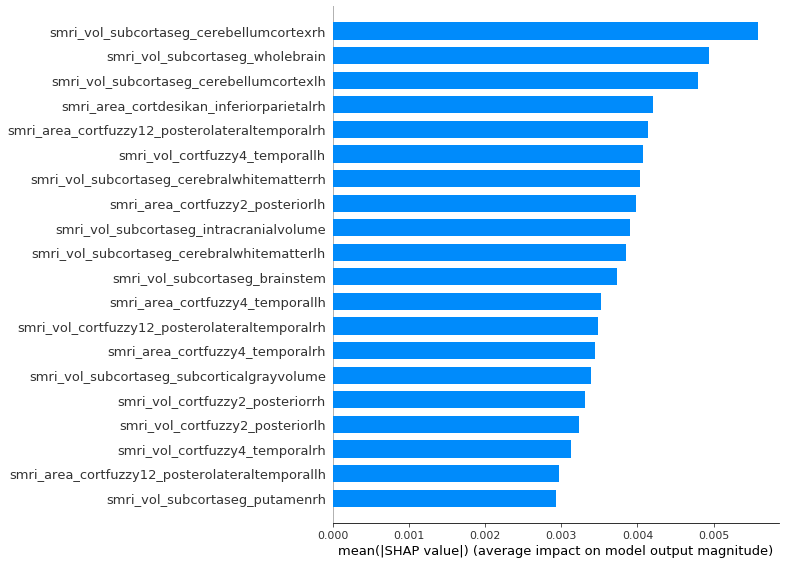

In [72]:
shap.summary_plot(mean_shap_values, train_data, plot_type="bar")

In [38]:
raw_scores = ML.Evaluate(model_type='linear')

Running Evaluate with:
model_type = linear
problem_type = binary
metric = ['macro roc auc', 'f1', 'accuracy']
data_scaler = standard
sampler = None
feat_selector = None
n_splits = 2
n_repeats = 1
int_cv = 3
ensemble_type = basic ensemble
ensemble_split = 0.2
search_type = None
model_type_param_ind = 0
data_scaler_param_ind = 0
sampler_param_ind = 0
feat_selector_param_ind = 0
class_weight = balanced
n_jobs = 8
n_iter = 8
random_state = 1
extra_params = {}



KeyboardInterrupt: 

Lets try with multiple data scalers now, just to show off that functionality, and still just the logistic regression.

In [ ]:
raw_scores = ML.Evaluate(model_type='logistic',
             data_scaler = ['robust', 'minmax'])

The robust scaler and minmax scaler seem to help a bit, so hey lets set that as our new default... just for fun.

Note when setting a new param, you do not need to repass in everything you are not changing!

In [ ]:
ML.Set_Default_ML_Params(data_scaler = ['robust', 'minmax'])

# Let make just take a look at the new default params, to make sure it is as expected
ML.default_ML_params

We can run a more complicated classifier, in particular, let's
try the light gradient boosting machine (LGBM) classifier, with a random search for parameters.
Note: The ' rs' at the end of the str model indicator is a special key for selecting the random parameter search option.

In [ ]:
raw_scores = ML.Evaluate(model_type='lgbm classifier',
                         search_type='random',
                         model_type_param_ind=1,
                         n_iter=2)

Interesting, the basic logistic regression seems to perform better then the more complex gradient boosting. One thing to note though is that we only tested 8 random sets of hyperparamers, what if we tried exploring a larger number? (This might take a while, especially if you are not running this on a powerful computer).

In [ ]:
raw_scores = ML.Evaluate(model_type='lgbm classifier rs',
                         n_iter=100)

That is still not all that big a boost from just a logistic regression.
We can still explore some other linear classifiers though.

In [ ]:
raw_scores = ML.Evaluate(model_type='ridge logistic rs')

In [ ]:
raw_scores = ML.Evaluate(model_type='knn classifier gs')

In [ ]:
raw_scores = ML.Evaluate(model_type='gaussian nb')

In [ ]:
#This is a gaussian process classifier
raw_scores = ML.Evaluate(model_type='gp')

In [ ]:
raw_scores = ML.Evaluate(model_type='elastic net logistic rs')

You could easily continue with the model exploration portion, but for this example, lets say we have explored enough.

# Testing Phase

In [ ]:
ML.Test(model_type ='ridge logistic rs')